<a href="https://colab.research.google.com/github/z-arabi/SRU-deeplearning-workshop/blob/master/25_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import getpass

kaggle_username = getpass.getpass('Enter your Kaggle username:')
kaggle_key = getpass.getpass('Enter your Kaggle API key:')

os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key

Enter your Kaggle username:··········
Enter your Kaggle API key:··········


In [2]:
!kaggle competitions download -c data-science-bowl-2018

 95% 342M/358M [00:02<00:00, 221MB/s]
100% 358M/358M [00:02<00:00, 148MB/s]


In [3]:
!mkdir data-science-bowl-2018
!unzip -q "data-science-bowl-2018.zip" -d "data-science-bowl-2018"

In [4]:
import os
import zipfile

base_dir = "data-science-bowl-2018"
files = os.listdir(base_dir)

for f in files:
  zip_file_path = os.path.join(base_dir, f)
  extract_to = os.path.join(base_dir,f[:-4])
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

In [5]:
print(os.listdir(base_dir))

['stage2_test_final', 'stage1_sample_submission.csv.zip', 'stage1_train_labels.csv.zip', 'stage1_solution.csv', 'stage2_sample_submission_final.csv', 'stage1_train.zip', 'stage1_sample_submission.csv', 'stage1_train', 'stage1_test.zip', 'stage1_solution.csv.zip', 'stage1_test', 'stage2_test_final.zip', 'stage1_train_labels.csv', 'stage2_sample_submission_final.csv.zip']


['2255d5aba044256bb92f6b7cbed0fca46d972c7b6b1a59dcbe7f682c5777d074.png']
['87db23bc612d5da66505569df4e1e195d5a2ccfe5a281e8e00880b4cf832ff19.png', '1647af216ee4b6396791edf91b50c28875ec38fa263496b73e63020f9a847521.png', '1e4c66f1d6c14ec40be7450d63fa0d10f416e37bd72614b3c11660b3d25406b0.png', '08709411036813c4427cd888c4ba608e54c28ca18625c2a9cad2def6920208ac.png', '3e584d4719ebabe2261ad100d4468d581d7eaeca28f038ba46caad6a96246278.png', '9f85f6800bc1ce400cc990895341e7d8818678acf80267a31efa359fe8db18ab.png', 'd9245e88e55d565d25cdd2dcc3386dba888019a2922aa90d2e82548a58cb3023.png', 'aaa6ddc7c3279473b650589f1e4cd7fad4a527428924c82a83d2f2cd13a7958d.png', '38d67da31c813a37ce9a9d4f80c79db465020d5b01e57f03d6bd45786fb7ad5f.png', '41b32f2cdd375e89be273b5c0254c3c6a4c7c9d89713683844e6bc0c1f4cf3e4.png', '84dd90b7ab0068c94f5d8f32bda935f5566df6c2af1461d83a712151d5a4931a.png', 'a2fb6c9b37917f8760a14e344f29ce274cdc730b1b03e5d3c2146165421c74bf.png', 'd0006c0a84418d55c51aac9357879e87236ddf400cba77799831006774128

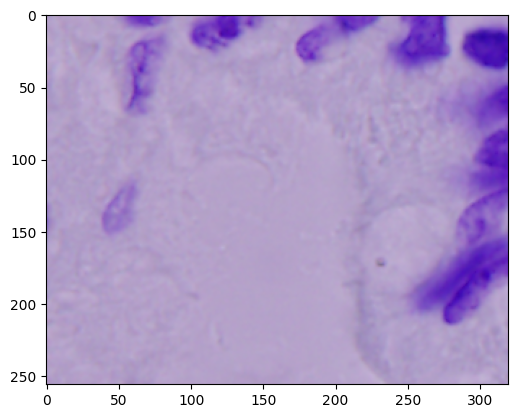

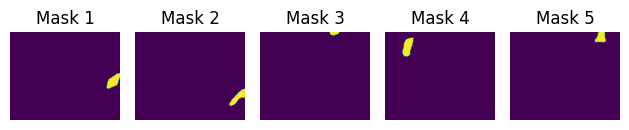

In [6]:
import matplotlib.pyplot as plt
import numpy as np

train_dir = os.path.join(base_dir, 'stage1_train')
sample = os.listdir(train_dir)[10]

images = os.path.join(train_dir, sample, 'images')
masks = os.path.join(train_dir, sample, 'masks')
print(os.listdir(images))
print(os.listdir(masks))

image = os.path.join(images,os.listdir(images)[0])
image = plt.imread(image)
print(np.array(image).shape)
image = image[:,:,:3]
plt.imshow(image)

print(len(os.listdir(masks)))
plt.figure()

for i in range(5):
    image_file = os.path.join(masks,os.listdir(masks)[i])
    img = plt.imread(image_file)
    print(np.array(img).shape)

    plt.subplot(1, 5, i + 1)

    plt.imshow(img)
    plt.title(f'Mask {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### U-Net Nuclei masks EDA
#### Part of Kaggle's 2018 Data Sciene Bowl
- https://www.kaggle.com/c/data-science-bowl-2018

#### Spot Nuclei. Speed Cures.

Imagine speeding up research for almost every disease, from lung cancer and heart disease to rare disorders. The 2018 Data Science Bowl offers our most ambitious mission yet: create an algorithm to automate nucleus detection.

We’ve all seen people suffer from diseases like cancer, heart disease, chronic obstructive pulmonary disease, Alzheimer’s, and diabetes. Many have seen their loved ones pass away. Think how many lives would be transformed if cures came faster.

By automating nucleus detection, you could help unlock cures faster—from rare disorders to the common cold. Want a snapshot about the 2018 Data Science Bowl? [View this video.](https://www.youtube.com/watch?v=eHwkfhmJexs&feature=youtu.be)

- Alot of the work in this notework was provided by Kjetil Åmdal-SævikKeras who made the "U-Net starter - LB 0.277" the top rated Kernel on Kaggle.
- https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277  

We can expand this for other uses, such as:
- changing the background of images
- detecting the noise in the images, it is better than the Autoencoders

In [7]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers import Dropout, Lambda
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = os.path.join(base_dir, 'stage1_train')
TEST_PATH = os.path.join(base_dir, 'stage1_test')

seed = 42
random.seed = seed
np.random.seed = seed

#### Collect our file names for training and test date

In [8]:
'''
Python function that generates the file names in a directory tree by walking either
top-down or bottom-up through the directory tree. It yields a tuple for each directory it visits,
containing three items:

The directory path as a string.
A list of subdirectories within the current directory.
A list of filenames within the current directory.
'''

'''
parent: data-science-bowl-2018
(data-science-bowl-2018, [subdirectories-Folders], [filenames-like zip files])
(data-science-bowl-2018/stage2_sample_submission_final.csv, [], ['stage2_sample_submission_final.csv']) >> finish
('data-science-bowl-2018/stage2_test_final', ['3a7bef2623e9dc39178d7f6280eaf86fe37df6674d0d85ca533ad2c34aa61abd', ...] , [])
('data-science-bowl-2018/stage2_test_final/3a7bef2623e9dc39178d7f6280eaf86fe37df6674d0d85ca533ad2c34aa61abd',
  ['images'],[])
('data-science-bowl-2018/stage2_test_final/3a7bef2623e9dc39178d7f6280eaf86fe37df6674d0d85ca533ad2c34aa61abd/images',
  [],['3a7bef2623e9dc39178d7f6280eaf86fe37df6674d0d85ca533ad2c34aa61abd.png']) >> finish
'''
os.walk(base_dir)

<generator object _walk at 0x7bd52909d150>

In [9]:
print(TRAIN_PATH)
len(list(os.walk(TRAIN_PATH)))
# You want to access to the ids and folders >> next >>
print(next(os.walk(TRAIN_PATH))[0])

walker = os.walk(TRAIN_PATH)
print(next(walker)[0])
print(next(walker)[0])
print(next(walker)[0])
print(next(walker)[0])
print(next(walker)[0])

data-science-bowl-2018/stage1_train
data-science-bowl-2018/stage1_train
data-science-bowl-2018/stage1_train
data-science-bowl-2018/stage1_train/d751ccb64fa767a65a966061218438bd1860695d96bbef11fdb2f0d3b8dedba8
data-science-bowl-2018/stage1_train/d751ccb64fa767a65a966061218438bd1860695d96bbef11fdb2f0d3b8dedba8/masks
data-science-bowl-2018/stage1_train/d751ccb64fa767a65a966061218438bd1860695d96bbef11fdb2f0d3b8dedba8/images
data-science-bowl-2018/stage1_train/1db1cddf28e305c9478519cfac144eee2242183fe59061f1f15487e925e8f5b5


In [10]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

#### Creating our image masks of dimension 128 x 128 (black images)

In [11]:
import sys

for i in range(10):
    print(f"Progress: {i}")
    sys.stdout.flush()  # Flush the buffer to display the progress immediately

Progress: 0
Progress: 1
Progress: 2
Progress: 3
Progress: 4
Progress: 5
Progress: 6
Progress: 7
Progress: 8
Progress: 9


In [12]:
print('Getting and resizing training images ... ')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

# Re-sizing our training images to 128 x 128
# Note sys.stdout prints info that can be cleared unlike print.
# Using TQDM allows us to create progress bars
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = os.path.join(TRAIN_PATH,id_)
    # it has 4 channels but you can drop the last
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

    # Now we take all masks associated with that image and combine them into one single mask
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        # we want to combine all masks in one mask > keep positive ones
        mask = np.maximum(mask, mask_)
    # Y_train is now our single mask associated with our image
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

# Here we resize our test images
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = os.path.join(TEST_PATH, id_)
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing training images ... 


100%|██████████| 670/670 [04:46<00:00,  2.34it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:01<00:00, 50.07it/s]

Done!


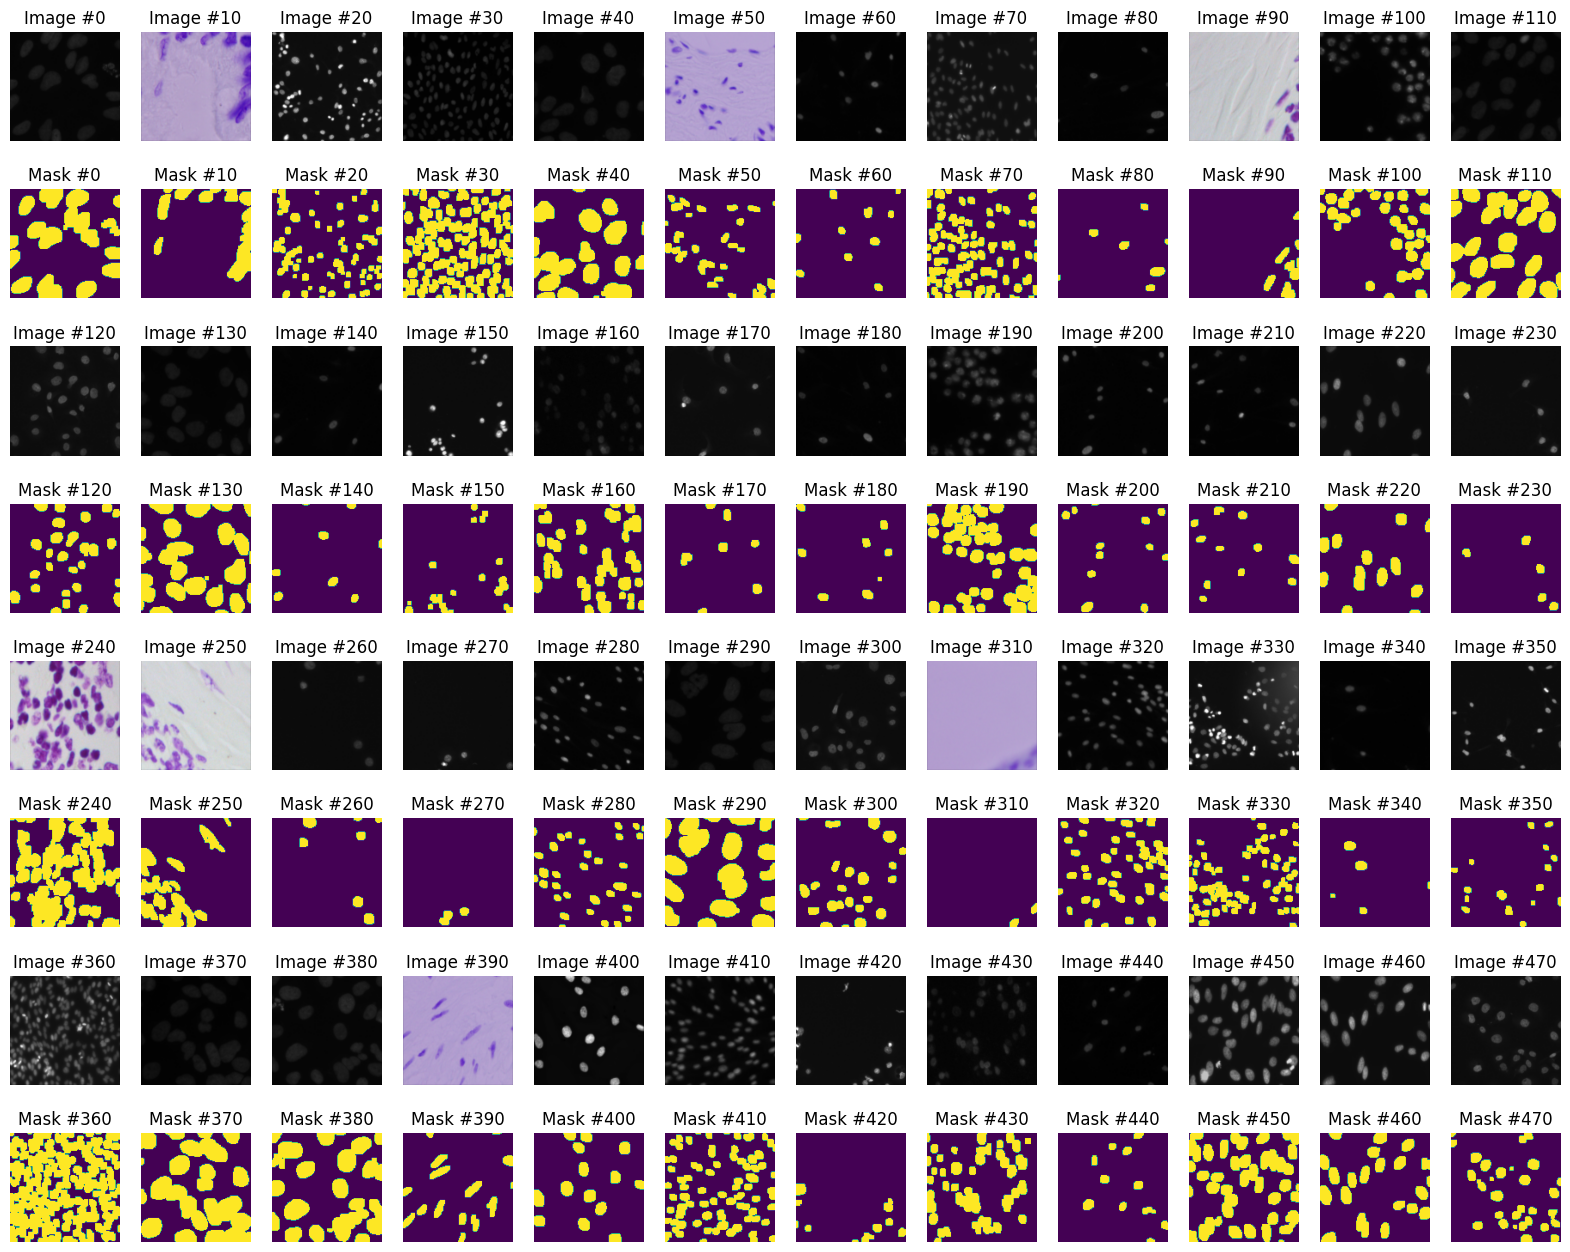

In [13]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):
    for j in range(x):
        # 8 rows and 12 columns
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.axis('off')
        plt.subplot(y*2, x, (i*2+1)*x+j+1)

        #We display the associated mask we just generated above with the training image > plot 2D
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.axis('off')

plt.show()

### Metric

#### Another IoU Metric  
- https://www.kaggle.com/aglotero/another-iou-metric
- https://www.kaggle.com/code/zahraarabi/all-the-segmentation-metrics/edit

Metrics to Evaluate your Semantic Segmentation Model

https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

1. We can use the pixel based accuracy. Compare the value of each pixel with the real one. Like MSE
2. IOU > Intersections Over Unions
3. Dice Coefficient (F1 score)

In [14]:
from keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

### Building our U-Net Model

In [15]:
# Build U-Net model
# Note we make our layers varaibles so that we can concatenate or stack
# This is required so that we can re-create our U-Net Model

inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# normalization layer
s = Lambda(lambda x: x / 255) (inputs)

# input: 128*128*3
c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (s)
# out > 128*128*16
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
# out > 128*128*16
p1 = MaxPooling2D((2, 2)) (c1)
# out > 64*64*16

c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
# out > 64*64*32
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (c2)
# out > 64*64*32
p2 = MaxPooling2D((2, 2)) (c2)
# out > 32*32*32

c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (p2)
# out > 32*32*64
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (c3)
# out > 32*32*64
p3 = MaxPooling2D((2, 2)) (c3)
# out > 16*16*64

c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (p3)
# out > 16*16*128
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', padding='same') (c4)
# out > 16*16*128
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
# out > 8*8*128

c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (p4)
# out > 8*8*256
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', padding='same') (c5)
# out > 8*8*256


# Decoder
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
# out > 16*16*128
u6 = concatenate([u6, c4])
# out > 16*16*256
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (u6)
# out > 16*16*128
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', padding='same') (c6)
# out > 16*16*128

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
# out > 32*32*64
u7 = concatenate([u7, c3])
# out > 32*32*128
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (u7)
# out > 32*32*64
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', padding='same') (c7)
# out > 32*32*64

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
# out > 64*64*32
u8 = concatenate([u8, c2])
# out > 64*64*64
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (u8)
# out > 64*64*32
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', padding='same') (c8)
# out > 64*64*32

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
# out > 128*128*16
u9 = concatenate([u9, c1], axis=3)
# out > 128*128*32
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (u9)
# out > 128*128*16
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', padding='same') (c9)
# out > 128*128*16

# Note our output is effectively a mask of 128 x 128
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
# out > 128*128*1

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                              

In [16]:
! pip install --quiet pydot graphviz

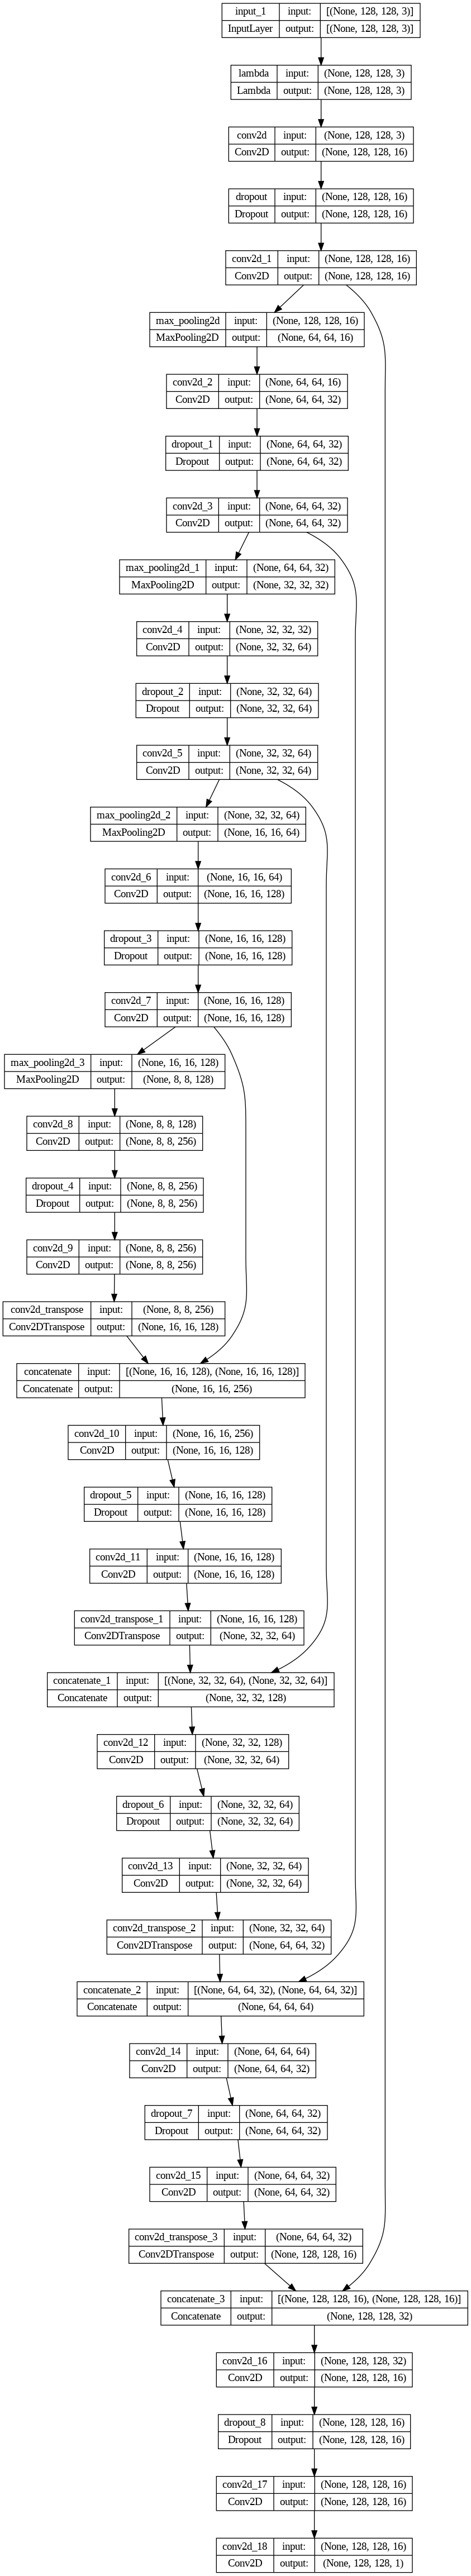

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

### Fit our model

In [18]:
# Initialize our callbacks
model_path = "./nuclei_finder_unet_1.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

# If the change is less than min_delta, it won't be counted as an improvement.
# Setting it to 0 means that any improvement, no matter how small, will be considered.
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

# Fit our model
results = model.fit(X_train, Y_train, validation_split=0.1,
                    batch_size=16, epochs=15,
                    callbacks=[earlystop, checkpoint])

Epoch 1/15
38/38 [==============================] - ETA: 0s - loss: 0.5838 - dice_coef: 0.2969
Epoch 1: val_loss improved from inf to 0.48065, saving model to ./nuclei_finder_unet_1.h5
38/38 [==============================] - 38s 122ms/step - loss: 0.5838 - dice_coef: 0.2969 - val_loss: 0.4807 - val_dice_coef: 0.3492
Epoch 2/15
 1/38 [..............................] - ETA: 1s - loss: 0.4724 - dice_coef: 0.3449

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/38 [============================>.] - ETA: 0s - loss: 0.3733 - dice_coef: 0.4464
Epoch 2: val_loss improved from 0.48065 to 0.29553, saving model to ./nuclei_finder_unet_1.h5
38/38 [==============================] - 2s 49ms/step - loss: 0.3736 - dice_coef: 0.4487 - val_loss: 0.2955 - val_dice_coef: 0.5261
Epoch 3/15
37/38 [============================>.] - ETA: 0s - loss: 0.2504 - dice_coef: 0.6318
Epoch 3: val_loss improved from 0.29553 to 0.22156, saving model to ./nuclei_finder_unet_1.h5
38/38 [==============================] - 2s 53ms/step - loss: 0.2508 - dice_coef: 0.6350 - val_loss: 0.2216 - val_dice_coef: 0.7077
Epoch 4/15
38/38 [==============================] - ETA: 0s - loss: 0.1788 - dice_coef: 0.7690
Epoch 4: val_loss improved from 0.22156 to 0.20365, saving model to ./nuclei_finder_unet_1.h5
38/38 [==============================] - 2s 52ms/step - loss: 0.1788 - dice_coef: 0.7690 - val_loss: 0.2036 - val_dice_coef: 0.7773
Epoch 5/15
37/38 [============================>.

### Generating our predictions for training and validation data

In [19]:
# Predict on training and validation data
# custom metric function dice_coef that was used during training.
model = load_model('./nuclei_finder_unet_1.h5',
                   custom_objects={'dice_coef': dice_coef})

# the first 90% was used for training
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)

# the last 10% used as validation
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

preds_test = model.predict(X_test, verbose=1)

# Threshold predictions = 0.5
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

print(preds_train[0][0][0], preds_train_t[0][0][0])

3/3 [==============================] - 0s 197ms/step
[0.1652676] [0]


### Showing our predicted masks on our training data

In [20]:
print(preds_train_t.shape)
print(Y_train.shape)
print(preds_train_t.min(), preds_train_t.max())
print(Y_train.min(), Y_train.max())
print(preds_val_t.astype(bool).min())

(603, 128, 128, 1)
(670, 128, 128, 1)
0 1
False True
False


/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


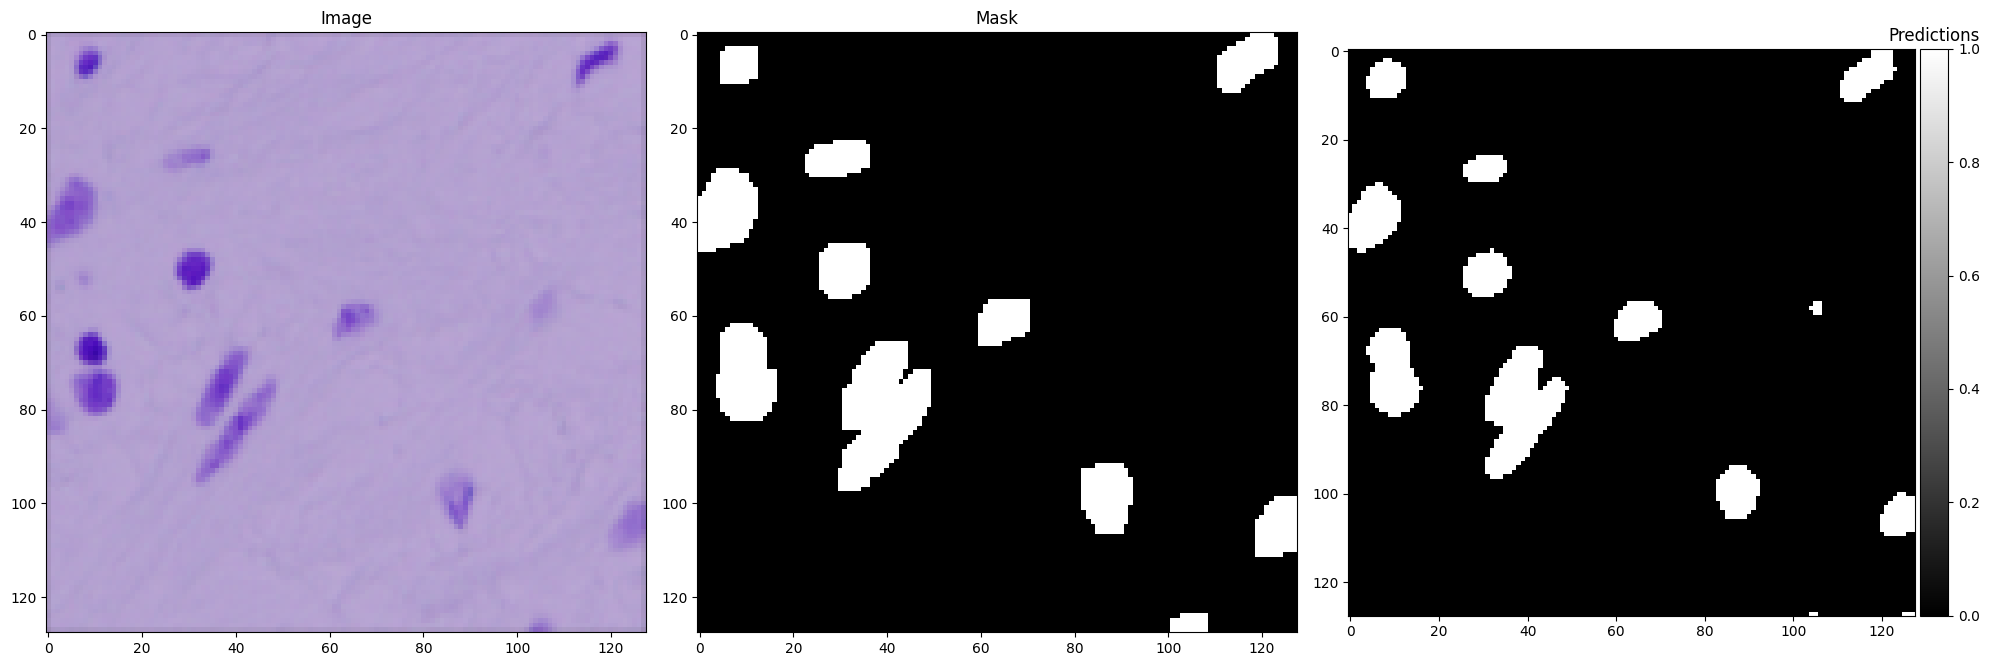

In [21]:
# Ploting our predicted masks
ix = random.randint(0, 602)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")

# Our original combined mask
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")

# The mask our U-Net model predicts
plt.subplot(133)
# imshow(np.squeeze(preds_train_t.astype(bool)[ix]))
imshow(np.squeeze(preds_train_t[ix]),cmap='gray')
plt.title("Predictions")
plt.show()

### Showing our predicted masks on our validation data

In [22]:
print(preds_test.shape[0])
print(X_test.shape[0])

65
65


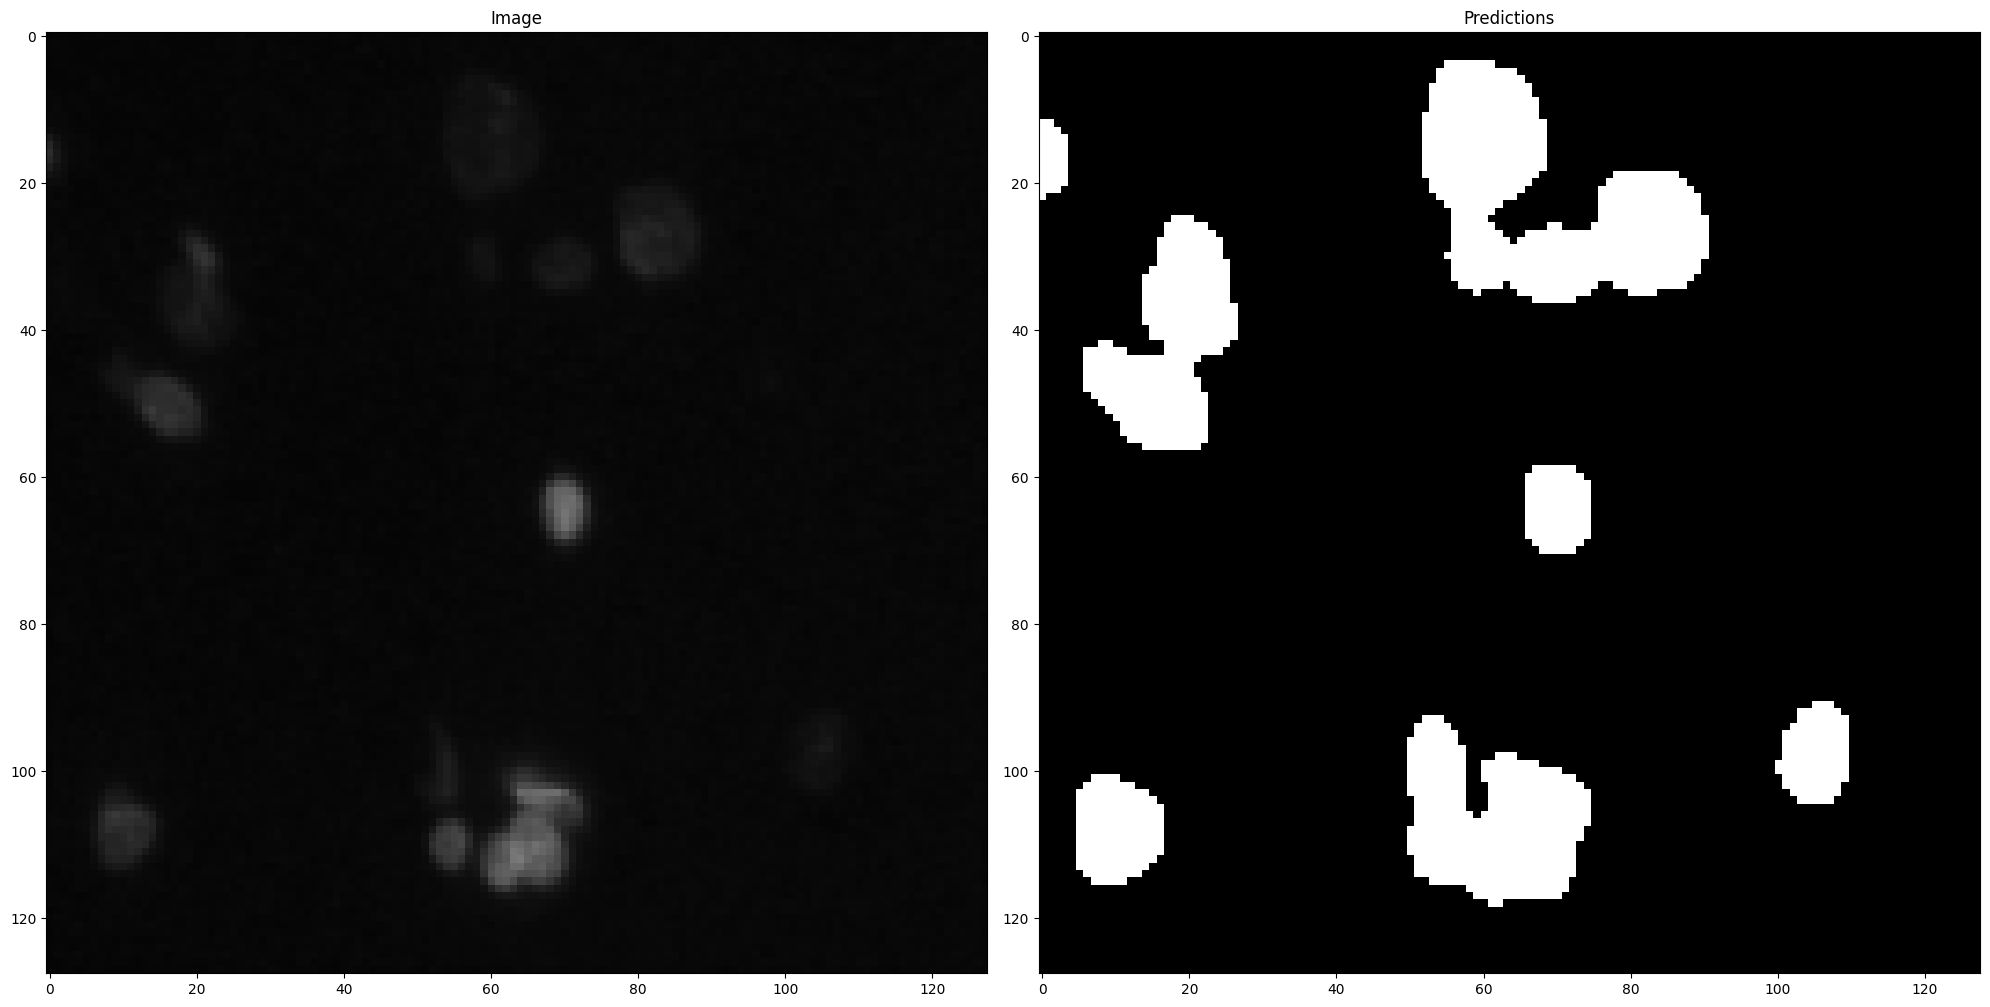

In [23]:
# Ploting our predicted masks
ix = random.randint(0, 65)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(121)
imshow(X_test[ix])
plt.title("Image")

# The mask our U-Net model predicts
plt.subplot(122)
imshow(np.squeeze(preds_test_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

### Generating a Classification Report

[False  True]
[0 1 2 3 4 5 6 7 8]
['area', 'area_bbox', 'area_convex', 'area_filled', 'axis_major_length', 'axis_minor_length', 'bbox', 'centroid', 'centroid_local', 'coords', 'eccentricity', 'equivalent_diameter_area', 'euler_number', 'extent', 'feret_diameter_max', 'image', 'image_convex', 'image_filled', 'inertia_tensor', 'inertia_tensor_eigvals', 'label', 'moments', 'moments_central', 'moments_hu', 'moments_normalized', 'orientation', 'perimeter', 'perimeter_crofton', 'slice', 'solidity']
1 (2.192982456140351, 30.789473684210527, 0.0)


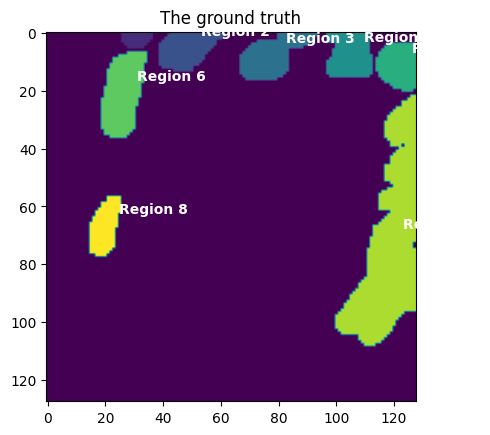

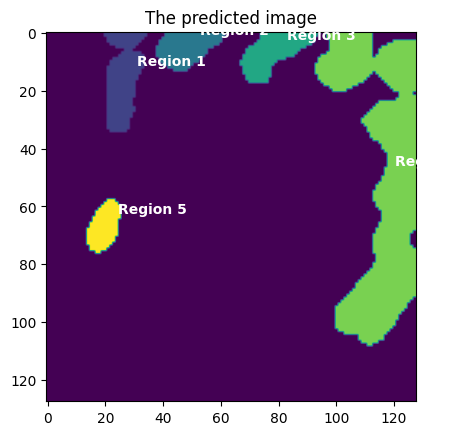

In [25]:
from skimage.morphology import label
from skimage.measure import regionprops

id = 10

# Y_train is boolean array > We need binary mask to perform labeling
# if the Y is not binary, you can add condition: y_true_in > 0.5
print(np.unique(Y_train[id]))

# When you apply the label function to the boolean mask, it performs connected component labeling.
# This process labels connected regions in the binary image. Each connected region is assigned a unique integer label.
y_label = label(Y_train[id])
print(np.unique(y_label))
plt.figure()
plt.title("The ground truth")
plt.imshow(y_label)

regions = regionprops(y_label)
print(list(regions[0]))
print(regions[0].label, regions[0].centroid)
# Annotate the plot with region labels
for region in regions:
    # specifies the position where the annotation will be placed. region.centroid is a property of
    # the region object that represents the centroid (center of mass) of the labeled region.
    # region.centroid[1] is the x-coordinate of the centroid, and region.centroid[0] is the y-coordinate.
    # xytext=(10, 10) specifies an offset in points for the text from the specified position.
    plt.annotate(f"Region {region.label}",
                 (region.centroid[1], region.centroid[0]),
                 color='white', fontsize=10, fontweight='bold',
                 xytext=(10, 10), textcoords='offset points')


labels = label(Y_train[id])
# tyep of preds_train_t[id] is int
y_pred = label(np.squeeze(preds_train_t[id]) > 0.5)
plt.figure()
plt.title("The predicted image")
plt.imshow(y_pred)

regions = regionprops(y_pred)
# Annotate the plot with region labels
for region in regions:
    plt.annotate(f"Region {region.label}",
                 (region.centroid[1], region.centroid[0]),
                 color='white', fontsize=10, fontweight='bold',
                 xytext=(10, 10), textcoords='offset points')


9 6
(128, 128, 1)
3 (9, 6) (10,) (7,)
[0.         0.88888889 1.77777778 2.66666667 3.55555556 4.44444444
 5.33333333 6.22222222 7.11111111 8.        ] [0.         0.83333333 1.66666667 2.5        3.33333333 4.16666667
 5.        ]


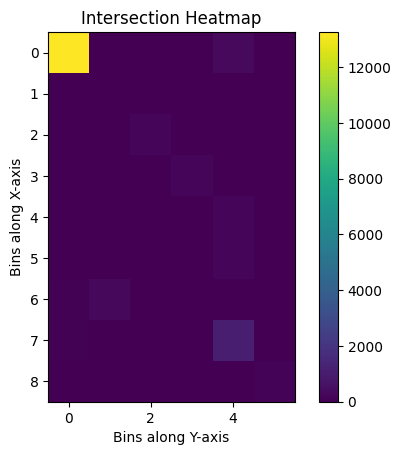

In [26]:
true_objects = len(np.unique(labels))
pred_objects = len(np.unique(y_pred))
print(true_objects, pred_objects)

print(labels.shape)
intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
# 17 for x-axis, 16 for y-axis, 18 Bin Edges along the X-Axis, 17 Bin Edges along the Y-Axis
print(len(intersection), intersection[0].shape, intersection[1].shape, intersection[2].shape)
print(intersection[1], intersection[2])

plt.figure()
plt.imshow(intersection[0], cmap='viridis')  # You can choose a colormap of your choice
plt.colorbar()  # Add a colorbar to show the scale
plt.title('Intersection Heatmap')
plt.xlabel('Bins along Y-axis')
plt.ylabel('Bins along X-axis')
plt.show()

(9,) (6,)


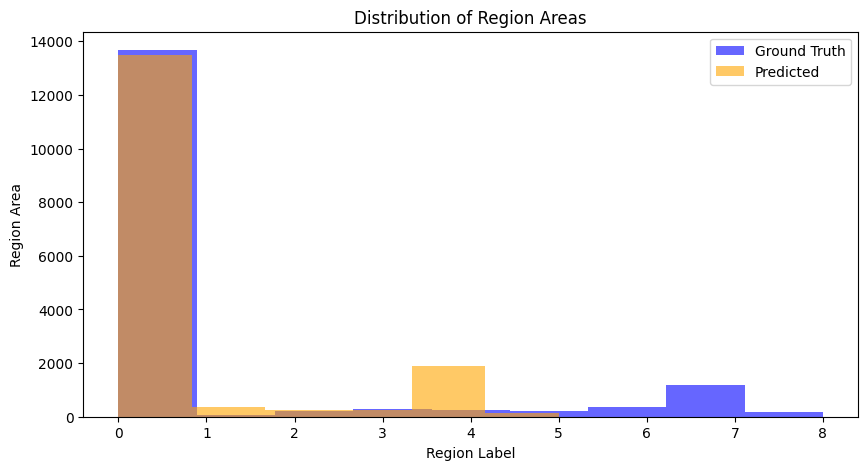

(9, 1) (1, 6)


In [27]:
area_true = np.histogram(labels, bins = true_objects)[0]
area_pred = np.histogram(y_pred, bins = pred_objects)[0]

print(area_true.shape, area_pred.shape)

plt.figure(figsize=(10, 5))
plt.hist(np.arange(len(area_true)), bins=len(area_true), weights=area_true, alpha=0.6, label='Ground Truth', color='blue')
plt.hist(np.arange(len(area_pred)), bins=len(area_pred), weights=area_pred, alpha=0.6, label='Predicted', color='orange')
plt.xlabel('Region Label')
plt.ylabel('Region Area')
plt.title('Distribution of Region Areas')
plt.legend()
plt.show()

area_true = np.expand_dims(area_true, -1)
area_pred = np.expand_dims(area_pred, 0)

print(area_true.shape, area_pred.shape)

(9, 6)


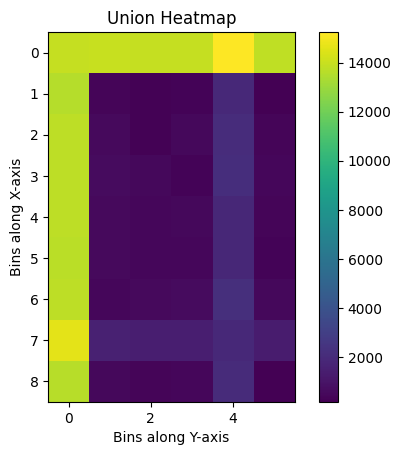

In [28]:
union = area_true + area_pred - intersection[0]
print(union.shape)
plt.figure()
plt.imshow(union, cmap='viridis')  # You can choose a colormap of your choice
plt.colorbar()  # Add a colorbar to show the scale
plt.title('Union Heatmap')
plt.xlabel('Bins along Y-axis')
plt.ylabel('Bins along X-axis')
plt.show()

(8, 5)


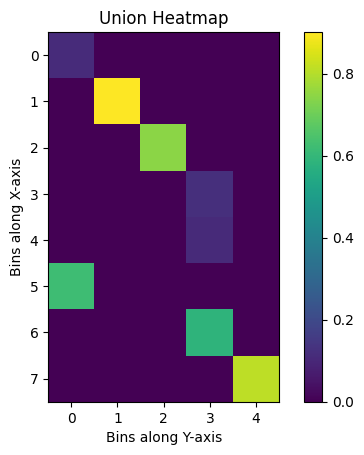

In [29]:
# Exclude background from the analysis
intersection = intersection[0]
intersection = intersection[1:,1:]
union = union[1:,1:]
union[union == 0] = 1e-9

# Compute the intersection over union
iou = intersection / union
print(iou.shape)
plt.figure()
plt.imshow(iou, cmap='viridis')  # You can choose a colormap of your choice
plt.colorbar()  # Add a colorbar to show the scale
plt.title('Union Heatmap')
plt.xlabel('Bins along Y-axis')
plt.ylabel('Bins along X-axis')
plt.show()

In [33]:
print(iou)

[[0.11263736 0.         0.         0.         0.        ]
 [0.         0.90163934 0.         0.         0.        ]
 [0.         0.         0.74598071 0.         0.        ]
 [0.         0.         0.         0.12320765 0.        ]
 [0.         0.         0.         0.10573858 0.        ]
 [0.62124711 0.         0.         0.         0.        ]
 [0.         0.         0.         0.58535327 0.        ]
 [0.         0.         0.         0.         0.81111111]]


In [30]:
matches = iou > 0.5
# row is the real data labels and column is the predicted data labels
print(matches.shape, iou.max(), iou.min())
print(matches)

(8, 5) 0.9016393442622951 0.0
[[False False False False False]
 [False  True False False False]
 [False False  True False False]
 [False False False False False]
 [False False False False False]
 [ True False False False False]
 [False False False  True False]
 [False False False False  True]]


In [36]:
# 16 is the y_test labels and 15 is the y_pred labels
# 16*1 > calculates the sum of True values along each row of the matches array.
print(np.sum(matches, axis=1))
print(np.sum(matches, axis=1) == 1)

# from the test labels how many you predict correctly [class=1]
# the true label is predicting > row*1 > positive = 1
true_positives = np.sum(matches, axis=1) == 1   # Correct objects
print(true_positives.shape)
# the predicted label is predicting > col*1 > false = 0
false_positives = np.sum(matches, axis=0) == 0  # Missed objects
print(false_positives.shape)
false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
print(false_negatives.shape)
tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
# the sum must be the labels of the real image
tp, fp, fn

[0 1 1 0 0 1 1 1]
[False  True  True False False  True  True  True]
(8,)
(5,)
(8,)


(5, 0, 3)

In [37]:
from skimage.morphology import label

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)

    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    # one image in each batch
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

iou_metric(np.squeeze(Y_train[ix]), np.squeeze(preds_train_t[ix]), print_table=True)

Thresh	TP	FP	FN	Prec.
0.500	2	1	0	0.667
0.550	2	1	0	0.667
0.600	2	1	0	0.667
0.650	2	1	0	0.667
0.700	2	1	0	0.667
0.750	2	1	0	0.667
0.800	2	1	0	0.667
0.850	2	1	0	0.667
0.900	1	2	1	0.250
0.950	0	3	2	0.000
AP	-	-	-	0.558


0.5583333333333333